# Pangeo - Global Surface Air Temperature changes in future scenarios

> This notebook is a reproducibility example of the IPCC-WGI AR6 Interactive Atlas products, which has been adapted to work with the ESGF Virtual Aggregation. This work is licensed under a [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0).
>
> ![Creative Commons License >](https://i.creativecommons.org/l/by/4.0/88x31.png)

**E. Cimadevilla** (Santander Meteorology Group. Instituto de Física de Cantabria, CSIC-UC, Santander, Spain).

This notebook computes Global Surface Air Temperature (GSAT) changes relative to the 1995–2014 and 1850–1900 averages, according to CMIP6 climate models.

This notebook works with data available in the [Google Cloud CMIP6 dataset](https://console.cloud.google.com/marketplace/product/noaa-public/cmip6). The Google Cloud CMIP6 data are derived from the original CMIP6 data files, as distributed via the Earth System Grid Federation (ESGF). Consistent with the CMIP6 terms of use, some modifications have been made to render the data more analysis-ready, including concatenation of time slices and conversion from netCDF to [Zarr](https://zarr.readthedocs.io/) format. All relevant metadata, including information about how to cite, are provided in the zarr metadata. The CMIP6 hosted on Google Cloud are maintained by the Climate Data Science Lab at Lamont Doherty Earth Observatory (LDEO) of Columbia University, as part of the [Pangeo Project](https://pangeo.io/) .

In [1]:
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cftime

import xarray
import dask

In [2]:
dask.config.set(scheduler="processes")

## Data catalog

The `gsat-pangeo.csv` catalog include the paths to the Google Cloud datasets considered in this notebook. We can analyze it with Pandas.

In [3]:
df = pd.read_csv("gsat-pangeo.csv")
df

,model_run,historical,ssp126,ssp245,ssp370,ssp585
0,AWI-CM-1-1-MR_r1i1p1f1,gs://cmip6/CMIP6/CMIP/AWI/AWI-CM-1-1-MR/histor...,gs://cmip6/CMIP6/ScenarioMIP/AWI/AWI-CM-1-1-MR...,gs://cmip6/CMIP6/ScenarioMIP/AWI/AWI-CM-1-1-MR...,gs://cmip6/CMIP6/ScenarioMIP/AWI/AWI-CM-1-1-MR...,gs://cmip6/CMIP6/ScenarioMIP/AWI/AWI-CM-1-1-MR...
1,CAMS-CSM1-0_r2i1p1f1,gs://cmip6/CMIP6/CMIP/CAMS/CAMS-CSM1-0/histori...,gs://cmip6/CMIP6/ScenarioMIP/CAMS/CAMS-CSM1-0/...,gs://cmip6/CMIP6/ScenarioMIP/CAMS/CAMS-CSM1-0/...,gs://cmip6/CMIP6/ScenarioMIP/CAMS/CAMS-CSM1-0/...,gs://cmip6/CMIP6/ScenarioMIP/CAMS/CAMS-CSM1-0/...
2,CanESM5_r1i1p1f1,gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/historical...,NaN,NaN,NaN,gs://cmip6/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp...
3,CESM2-WACCM_r1i1p1f1,gs://cmip6/CMIP6/CMIP/NCAR/CESM2-WACCM/histori...,NaN,NaN,NaN,gs://cmip6/CMIP6/ScenarioMIP/NCAR/CESM2-WACCM/...
4,CMCC-CM2-SR5_r1i1p1f1,gs://cmip6/CMIP6/CMIP/CMCC/CMCC-CM2-SR5/histor...,gs://cmip6/CMIP6/ScenarioMIP/CMCC/CMCC-CM2-SR5...,gs://cmip6/CMIP6/ScenarioMIP/CMCC/CMCC-CM2-SR5...,gs://cmip6/CMIP6/ScenarioMIP/CMCC/CMCC-CM2-SR5...,gs://cmip6/CMIP6/ScenarioMIP/CMCC/CMCC-CM2-SR5...
5,CNRM-CM6-1_r1i1p1f2,gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-CM6-1/...,gs://cmip6/CMIP6/ScenarioMIP/CNRM-CERFACS/CNRM...,gs://cmip6/CMIP6/ScenarioMIP/CNRM-CERFACS/CNRM...,gs://cmip6/CMIP6/ScenarioMIP/CNRM-CERFACS/CNRM...,gs://cmip6/CMIP6/ScenarioMIP/CNRM-CERFACS/CNRM...
6,CNRM-CM6-1-HR_r1i1p1f2,gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-CM6-1-...,NaN,NaN,NaN,gs://cmip6/CMIP6/ScenarioMIP/CNRM-CERFACS/CNRM...
7,CNRM-ESM2-1_r1i1p1f2,gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1...,gs://cmip6/CMIP6/ScenarioMIP/CNRM-CERFACS/CNRM...,NaN,gs://cmip6/CMIP6/ScenarioMIP/CNRM-CERFACS/CNRM...,gs://cmip6/CMIP6/ScenarioMIP/CNRM-CERFACS/CNRM...
8,GFDL-CM4_r1i1p1f1,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/histo...,NaN,NaN,NaN,NaN
9,GFDL-ESM4_r1i1p1f1,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/hist...,gs://cmip6/CMIP6/ScenarioMIP/NOAA-GFDL/GFDL-ES...,NaN,NaN,NaN


## Data loading

We load the data into [xarray](https://docs.xarray.dev/en/stable/) datasets, since xarray is compatible with [Zarr](https://docs.xarray.dev/en/stable/user-guide/io.html#zarr).

In [4]:
def load_datasets_pangeo(locations, experiment):
    dss = []
    for location in locations:
        if location is np.nan:
            continue

        model = location.split("/")[6]
        member = location.split("/")[8]

        ds = xarray.open_zarr(
            location,
            drop_variables=["time_bnds", "lat_bnds", "lon_bnds"])

        if experiment.startswith("ssp"):
            ds = ds.isel(time=slice(None, 31390))
            # limit to 2100, avoid cf time indexing issues
            if isinstance(ds["time"][0].item(), cftime.Datetime360Day):
                ds = ds.sel(time=slice("20150101", "21001230"))
            else:
                ds = ds.sel(time=slice("20150101", "21001231"))
        elif experiment == "historical":
            pass
        else:
            raise ValueError("Invalid experiment... exiting")
    
        # add the model_run global attribute
        ds.attrs["model_run"] = f"{model}_{member}"
        dss.append(ds)

    return dss

Load the different scenarios.

In [5]:
historical_dss = load_datasets_pangeo(df["historical"], "historical")
ssp126_dss = load_datasets_pangeo(df["ssp126"], "ssp126")
ssp245_dss = load_datasets_pangeo(df["ssp245"], "ssp245")
ssp370_dss = load_datasets_pangeo(df["ssp370"], "ssp370")
ssp585_dss = load_datasets_pangeo(df["ssp585"], "ssp585")

/tmp/ipykernel_1082069/2736826303.py:10: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  ds = xarray.open_zarr(


Preview one of the datasets.

In [6]:
historical_dss[0]["tas"]

<xarray.DataArray 'tas' (time: 60265, lat: 192, lon: 384)> Size: 18GB
dask.array<open_dataset-tas, shape=(60265, 192, 384), dtype=float32, chunksize=(221, 192, 384), chunktype=numpy.ndarray>
Coordinates:
    height   float64 8B ...
  * lat      (lat) float64 2kB -89.28 -88.36 -87.42 -86.49 ... 87.42 88.36 89.28
  * lon      (lon) float64 3kB 0.0 0.9375 1.875 2.812 ... 357.2 358.1 359.1
  * time     (time) datetime64[ns] 482kB 1850-01-01T12:00:00 ... 2014-12-31T1...
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    comment:        near-surface (usually, 2 meter) air temperature
    long_name:      Near-Surface Air Temperature
    original_name:  temp2
    standard_name:  air_temperature
    units:          K

## Computation

The functions that compute global surface average temperatures (GSAT) is available in the `gsat.py` module. We implement weighted and unweighted GSAT.

In [7]:
from gsat import weighted, unweighted

### Weighted

Due to the implementation of weighted operations between xarray and Dask, this operation is more expensive in comparison with the unweighted version. This is due to Dask tasks that have to wait for each other in order to carry out weighted operations.

In [8]:
%%time

mean_hist_1995_2014, mean_hist_1850_1900, mean_hist, mean_ssp126, mean_ssp245, mean_ssp370, mean_ssp585 = weighted(
    8,
    historical_dss, ssp126_dss, ssp245_dss, ssp370_dss, ssp585_dss)

Model_run: AWI-CM-1-1-MR_r1i1p1f1
Model_run: CAMS-CSM1-0_r2i1p1f1
Model_run: CanESM5_r1i1p1f1
Model_run: CESM2-WACCM_r1i1p1f1
Model_run: CMCC-CM2-SR5_r1i1p1f1
Model_run: CNRM-CM6-1_r1i1p1f2
Model_run: CNRM-CM6-1-HR_r1i1p1f2
Model_run: CNRM-ESM2-1_r1i1p1f2
Model_run: GFDL-CM4_r1i1p1f1
Model_run: GFDL-ESM4_r1i1p1f1
Model_run: HadGEM3-GC31-LL_r1i1p1f3
Model_run: IITM-ESM_r1i1p1f1
Model_run: INM-CM4-8_r1i1p1f1
Model_run: INM-CM5-0_r1i1p1f1
Model_run: IPSL-CM6A-LR_r1i1p1f1
Model_run: MPI-ESM1-2-HR_r1i1p1f1
Model_run: MPI-ESM1-2-LR_r1i1p1f1
Model_run: MRI-ESM2-0_r1i1p1f1
Model_run: NorESM2-LM_r1i1p1f1
Model_run: NorESM2-MM_r1i1p1f1
Model_run: TaiESM1_r1i1p1f1
Model_run: UKESM1-0-LL_r1i1p1f2
CPU times: user 31min 55s, sys: 1h 30min 47s, total: 2h 2min 42s
Wall time: 3h 9min 43s


In [11]:
m_hist   = (mean_hist   - mean_hist_1995_2014).resample({"time": "YE"}).mean().mean("member").isel(time=slice(None,-1))["tas"]
m_ssp126 = (mean_ssp126 - mean_hist_1995_2014).resample({"time": "YE"}).mean().mean("member").isel(time=slice(None,-1))["tas"]
m_ssp245 = (mean_ssp245 - mean_hist_1995_2014).resample({"time": "YE"}).mean().mean("member").isel(time=slice(None,-1))["tas"]
m_ssp370 = (mean_ssp370 - mean_hist_1995_2014).resample({"time": "YE"}).mean().mean("member").isel(time=slice(None,-1))["tas"]
m_ssp585 = (mean_ssp585 - mean_hist_1995_2014).resample({"time": "YE"}).mean().mean("member").isel(time=slice(None,-1))["tas"]

m_hist_18   = (mean_hist   - mean_hist_1850_1900).resample({"time": "YE"}).mean().mean("member").isel(time=slice(None,-1))["tas"]
m_ssp126_18 = (mean_ssp126 - mean_hist_1850_1900).resample({"time": "YE"}).mean().mean("member").isel(time=slice(None,-1))["tas"]
m_ssp245_18 = (mean_ssp245 - mean_hist_1850_1900).resample({"time": "YE"}).mean().mean("member").isel(time=slice(None,-1))["tas"]
m_ssp370_18 = (mean_ssp370 - mean_hist_1850_1900).resample({"time": "YE"}).mean().mean("member").isel(time=slice(None,-1))["tas"]
m_ssp585_18 = (mean_ssp585 - mean_hist_1850_1900).resample({"time": "YE"}).mean().mean("member").isel(time=slice(None,-1))["tas"]

q_hist   = (mean_hist   - mean_hist_1995_2014).resample({"time": "YE"}).mean().quantile([.05, .95], dim=["member"]).isel(time=slice(None,-1))["tas"]
q_ssp126 = (mean_ssp126 - mean_hist_1995_2014).resample({"time": "YE"}).mean().quantile([.05, .95], dim=["member"]).isel(time=slice(None,-1))["tas"]
q_ssp370 = (mean_ssp370 - mean_hist_1995_2014).resample({"time": "YE"}).mean().quantile([.05, .95], dim=["member"]).isel(time=slice(None,-1))["tas"]
q_ssp585 = (mean_ssp585 - mean_hist_1995_2014).resample({"time": "YE"}).mean().quantile([.05, .95], dim=["member"]).isel(time=slice(None,-1))["tas"]

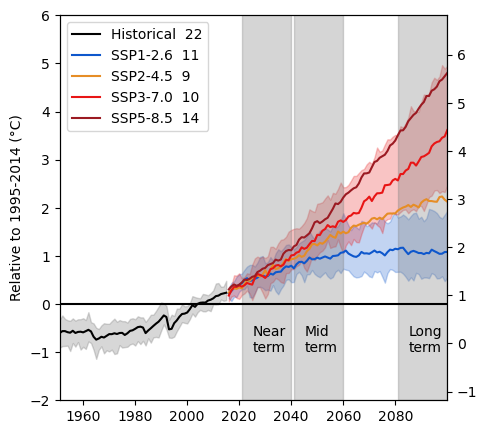

In [12]:
fig, ax = plt.subplots(figsize=(5,5))

ax.fill_between(q_hist.time,
                q_hist.sel(quantile=.05),
                q_hist.sel(quantile=.95),
                color="#616161", alpha=0.25)
ax.fill_between(q_ssp126.time,
                q_ssp126.sel(quantile=.05),
                q_ssp126.sel(quantile=.95),
                color="#0e57cc", alpha=0.25)
ax.fill_between(q_ssp370.time,
                q_ssp370.sel(quantile=.05),
                q_ssp370.sel(quantile=.95),
                color="#e81515", alpha=0.25)

ytop = 6
ax.set_ylabel("Relative to 1995-2014 (°C)")
ax.axhline(y=0, color="black")
ax.text(np.datetime64('2024-12-31T00:00:00.000000000'), -1, "Near\nterm")
ax.text(np.datetime64('2044-12-31T00:00:00.000000000'), -1, "Mid\nterm")
ax.text(np.datetime64('2084-12-31T00:00:00.000000000'), -1, "Long\nterm")
ax.fill_between(
    m_ssp126["time"].sel(time=slice("20200101", "20400101")),
    -2, ytop+.82, alpha=.33, color="grey")
ax.fill_between(
     m_ssp126["time"].sel(time=slice("20400101", "20600101")),
    -2, ytop+.82, alpha=.33, color="grey")
ax.fill_between(
     m_ssp126["time"].sel(time=slice("20800101", None)),
    -2, ytop+.82, alpha=.33, color="grey")

ax2 = ax.twinx()
ax2.set_ylim(bottom=-2+.82, top=ytop+.82)
ax.set_ylim([-2, ytop])

ax.plot(m_hist.time, m_hist, color="#010101", label=f"Historical  {len(mean_hist['member'])}")
ax.plot(m_ssp126.time, m_ssp126, color="#0e57cc", label=f"SSP1-2.6  {len(mean_ssp126['member'])}")
ax.plot(m_ssp245.time, m_ssp245, color="#e68d26", label=f"SSP2-4.5  {len(mean_ssp245['member'])}")
ax.plot(m_ssp370.time, m_ssp370, color="#e81515", label=f"SSP3-7.0  {len(mean_ssp370['member'])}")
ax.plot(m_ssp585.time, m_ssp585, color="#9b1a22", label=f"SSP5-8.5  {len(mean_ssp585['member'])}")

# ax2.plot(m_hist_18.time, m_hist_18, color="#010101", label=f"Historical  {len(mean_hist['member'])}")
# ax2.plot(m_ssp126_18.time, m_ssp126_18, color="#0e57cc", label=f"SSP1-2.6  {len(mean_ssp126['member'])}")
# ax2.plot(m_ssp245_18.time, m_ssp245_18, color="#e68d26", label=f"SSP2-4.5  {len(mean_ssp245['member'])}")
# ax2.plot(m_ssp370_18.time, m_ssp370_18, color="#e81515", label=f"SSP3-7.0  {len(mean_ssp370['member'])}")
# ax2.plot(m_ssp585_18.time, m_ssp585_18, color="#9b1a22", label=f"SSP5-8.5  {len(mean_ssp585['member'])}")

ax.margins(0)
ax2.margins(0)
ax.legend()

plt.savefig("pangeo-weighted.pdf")

### Unweighted

In contrast to the weighted version, unweighted tasks in the Dask graph do not depend on each other for the computation of the final result. Thus, we can measure the actual throughtput of the infrastructure, since we are not spending time within the computation runtime.

260 GB

In [13]:
%%time

un_mean_hist_1995_2014, un_mean_hist_1850_1900, un_mean_hist, un_mean_ssp126, un_mean_ssp245, un_mean_ssp370, un_mean_ssp585 = unweighted(
    8,
    historical_dss, ssp126_dss, ssp245_dss, ssp370_dss, ssp585_dss)

Model_run: AWI-CM-1-1-MR_r1i1p1f1
Model_run: CAMS-CSM1-0_r2i1p1f1
Model_run: CanESM5_r1i1p1f1
Model_run: CESM2-WACCM_r1i1p1f1
Model_run: CMCC-CM2-SR5_r1i1p1f1
Model_run: CNRM-CM6-1_r1i1p1f2
Model_run: CNRM-CM6-1-HR_r1i1p1f2
Model_run: CNRM-ESM2-1_r1i1p1f2
Model_run: GFDL-CM4_r1i1p1f1
Model_run: GFDL-ESM4_r1i1p1f1
Model_run: HadGEM3-GC31-LL_r1i1p1f3
Model_run: IITM-ESM_r1i1p1f1
Model_run: INM-CM4-8_r1i1p1f1
Model_run: INM-CM5-0_r1i1p1f1
Model_run: IPSL-CM6A-LR_r1i1p1f1
Model_run: MPI-ESM1-2-HR_r1i1p1f1
Model_run: MPI-ESM1-2-LR_r1i1p1f1
Model_run: MRI-ESM2-0_r1i1p1f1
Model_run: NorESM2-LM_r1i1p1f1
Model_run: NorESM2-MM_r1i1p1f1
Model_run: TaiESM1_r1i1p1f1
Model_run: UKESM1-0-LL_r1i1p1f2
CPU times: user 1min 27s, sys: 1.9 s, total: 1min 29s
Wall time: 1h 30min 58s


In [14]:
m_hist   = (un_mean_hist   - un_mean_hist_1995_2014).resample({"time": "YE"}).mean().mean("member").isel(time=slice(None,-1))["tas"]
m_ssp126 = (un_mean_ssp126 - un_mean_hist_1995_2014).resample({"time": "YE"}).mean().mean("member").isel(time=slice(None,-1))["tas"]
m_ssp245 = (un_mean_ssp245 - un_mean_hist_1995_2014).resample({"time": "YE"}).mean().mean("member").isel(time=slice(None,-1))["tas"]
m_ssp370 = (un_mean_ssp370 - un_mean_hist_1995_2014).resample({"time": "YE"}).mean().mean("member").isel(time=slice(None,-1))["tas"]
m_ssp585 = (un_mean_ssp585 - un_mean_hist_1995_2014).resample({"time": "YE"}).mean().mean("member").isel(time=slice(None,-1))["tas"]

m_hist_18   = (un_mean_hist   - un_mean_hist_1850_1900).resample({"time": "YE"}).mean().mean("member").isel(time=slice(None,-1))["tas"]
m_ssp126_18 = (un_mean_ssp126 - un_mean_hist_1850_1900).resample({"time": "YE"}).mean().mean("member").isel(time=slice(None,-1))["tas"]
m_ssp245_18 = (un_mean_ssp245 - un_mean_hist_1850_1900).resample({"time": "YE"}).mean().mean("member").isel(time=slice(None,-1))["tas"]
m_ssp370_18 = (un_mean_ssp370 - un_mean_hist_1850_1900).resample({"time": "YE"}).mean().mean("member").isel(time=slice(None,-1))["tas"]
m_ssp585_18 = (un_mean_ssp585 - un_mean_hist_1850_1900).resample({"time": "YE"}).mean().mean("member").isel(time=slice(None,-1))["tas"]

q_hist   = (un_mean_hist   - un_mean_hist_1995_2014).resample({"time": "YE"}).mean().quantile([.05, .95], dim=["member"]).isel(time=slice(None,-1))["tas"]
q_ssp126 = (un_mean_ssp126 - un_mean_hist_1995_2014).resample({"time": "YE"}).mean().quantile([.05, .95], dim=["member"]).isel(time=slice(None,-1))["tas"]
q_ssp370 = (un_mean_ssp370 - un_mean_hist_1995_2014).resample({"time": "YE"}).mean().quantile([.05, .95], dim=["member"]).isel(time=slice(None,-1))["tas"]
q_ssp585 = (un_mean_ssp585 - un_mean_hist_1995_2014).resample({"time": "YE"}).mean().quantile([.05, .95], dim=["member"]).isel(time=slice(None,-1))["tas"]

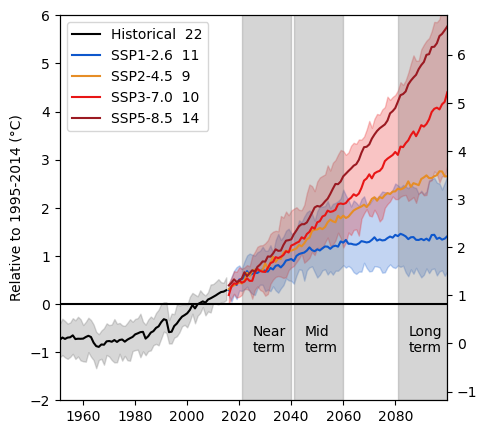

In [15]:
fig, ax = plt.subplots(figsize=(5,5))

ax.fill_between(q_hist.time,
                q_hist.sel(quantile=.05),
                q_hist.sel(quantile=.95),
                color="#616161", alpha=0.25)
ax.fill_between(q_ssp126.time,
                q_ssp126.sel(quantile=.05),
                q_ssp126.sel(quantile=.95),
                color="#0e57cc", alpha=0.25)
ax.fill_between(q_ssp370.time,
                q_ssp370.sel(quantile=.05),
                q_ssp370.sel(quantile=.95),
                color="#e81515", alpha=0.25)

ytop = 6
ax.set_ylabel("Relative to 1995-2014 (°C)")
ax.axhline(y=0, color="black")
ax.text(np.datetime64('2024-12-31T00:00:00.000000000'), -1, "Near\nterm")
ax.text(np.datetime64('2044-12-31T00:00:00.000000000'), -1, "Mid\nterm")
ax.text(np.datetime64('2084-12-31T00:00:00.000000000'), -1, "Long\nterm")
ax.fill_between(
    m_ssp126["time"].sel(time=slice("20200101", "20400101")),
    -2, ytop+.82, alpha=.33, color="grey")
ax.fill_between(
     m_ssp126["time"].sel(time=slice("20400101", "20600101")),
    -2, ytop+.82, alpha=.33, color="grey")
ax.fill_between(
     m_ssp126["time"].sel(time=slice("20800101", None)),
    -2, ytop+.82, alpha=.33, color="grey")

ax2 = ax.twinx()
ax2.set_ylim(bottom=-2+.82, top=ytop+.82)
ax.set_ylim([-2, ytop])

ax.plot(m_hist.time, m_hist, color="#010101", label=f"Historical  {len(un_mean_hist['member'])}")
ax.plot(m_ssp126.time, m_ssp126, color="#0e57cc", label=f"SSP1-2.6  {len(un_mean_ssp126['member'])}")
ax.plot(m_ssp245.time, m_ssp245, color="#e68d26", label=f"SSP2-4.5  {len(un_mean_ssp245['member'])}")
ax.plot(m_ssp370.time, m_ssp370, color="#e81515", label=f"SSP3-7.0  {len(un_mean_ssp370['member'])}")
ax.plot(m_ssp585.time, m_ssp585, color="#9b1a22", label=f"SSP5-8.5  {len(un_mean_ssp585['member'])}")

# ax2.plot(m_hist_18.time, m_hist_18, color="#010101", label=f"Historical  {len(mean_hist['member'])}")
# ax2.plot(m_ssp126_18.time, m_ssp126_18, color="#0e57cc", label=f"SSP1-2.6  {len(mean_ssp126['member'])}")
# ax2.plot(m_ssp245_18.time, m_ssp245_18, color="#e68d26", label=f"SSP2-4.5  {len(mean_ssp245['member'])}")
# ax2.plot(m_ssp370_18.time, m_ssp370_18, color="#e81515", label=f"SSP3-7.0  {len(mean_ssp370['member'])}")
# ax2.plot(m_ssp585_18.time, m_ssp585_18, color="#9b1a22", label=f"SSP5-8.5  {len(mean_ssp585['member'])}")

ax.margins(0)
ax2.margins(0)
ax.legend()

plt.savefig("pangeo-unweighted.pdf")